# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model
from matplotlib import pyplot as pl
from sklearn import metrics as me

from utils import plot_confusion_matrix

%matplotlib inline

2023-04-30 17:06:23.670201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 17:06:24.091420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


First, create some useful functions

In [2]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()

    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0 * array.shape[1], dim_0 * array.shape[2]))


def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0] + 0.5, temp_out.shape[1]))
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0] + 0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off',
                   labelleft='off')
    pl.title(title)


def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1]) - 0.4, temp_out[0, :])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


In [4]:
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)

X_train.shape =  (60000, 28, 28, 1)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 28, 28, 1)
Y_test.shape =  (10000, 10)


Create the CNN and show its architecture

In [5]:
model = Sequential([
    Input(shape=(height, width, 1), name='l0'),
    
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='l1'),
    MaxPooling2D(pool_size=(2, 2), name='l1_mp'),
    Dropout(0.1, name='l1_drop'),
    
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='l2'),
    MaxPooling2D(pool_size=(2, 2), name='l2_mp'),
    Dropout(0.1, name='l2_drop'),
    
    Flatten(name='flat'),
    Dropout(0.2, name='drop'),
    
    Dense(n_classes, activation='softmax', name='l3'),
])

2023-04-30 17:06:25.094420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:06:25.103130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:06:25.103177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:06:25.104782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:06:25.104823: I tensorflow/compile

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Conv2D)                 (None, 28, 28, 32)        320       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 l1_drop (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 64)        18496     
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 64)          0         
                                                                 
 l2_drop (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flat (Flatten)              (None, 3136)              0

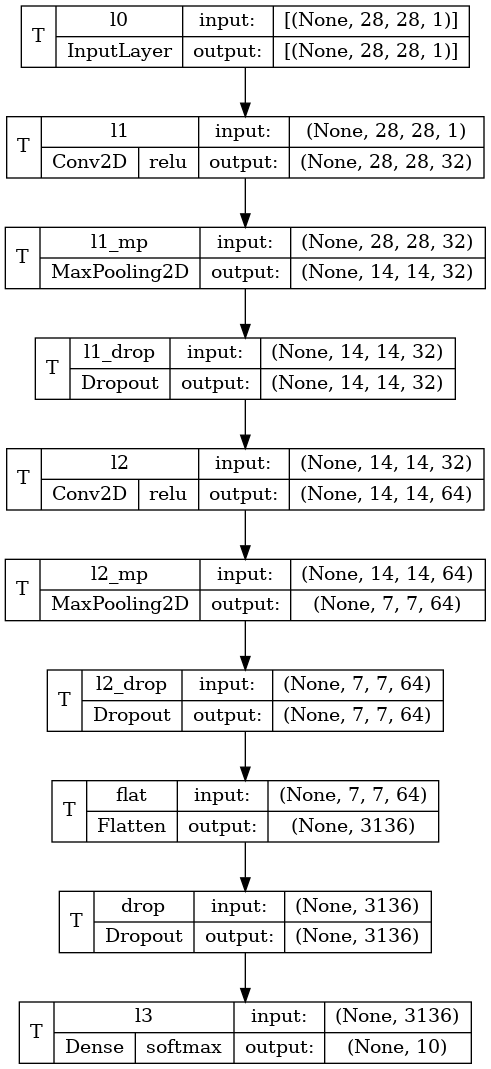

In [7]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True,
    to_file='mnist-model.png'
)

Define some constants and train de CNN

In [8]:
batch_size = 128
n_epoch = 15

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.1)

Epoch 1/15


2023-04-30 17:06:26.719638: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/l1_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-30 17:06:27.631547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-30 17:06:28.783912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


422/422 [==============================] - 6s 8ms/step - loss: 0.2824 - accuracy: 0.9137 - val_loss: 0.0854 - val_accuracy: 0.9738
Epoch 2/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0888 - accuracy: 0.9728 - val_loss: 0.0568 - val_accuracy: 0.9838
Epoch 3/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0662 - accuracy: 0.9797 - val_loss: 0.0474 - val_accuracy: 0.9867
Epoch 4/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0539 - accuracy: 0.9833 - val_loss: 0.0421 - val_accuracy: 0.9890
Epoch 5/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0487 - accuracy: 0.9851 - val_loss: 0.0384 - val_accuracy: 0.9900
Epoch 6/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0433 - accuracy: 0.9871 - val_loss: 0.0386 - val_accuracy: 0.9900
Epoch 7/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0387 - accuracy: 0.9886 - val_loss: 0.0375 - val_accuracy: 0.9902
Epoch 8/15
422/42

Show the performance of the model

Test score: 0.023659802973270416
Test accuracy: 0.9926000237464905


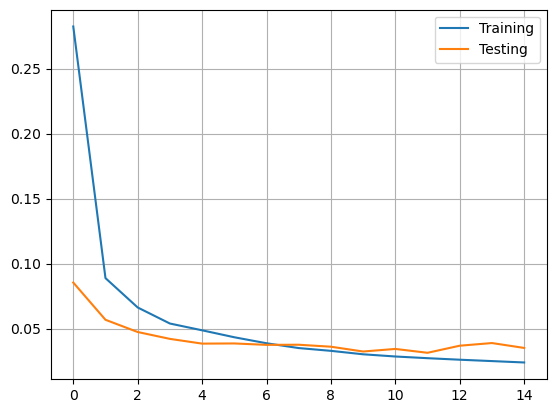

In [9]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

313/313 [==============================] - 0s 1ms/step
pred.shape =  (10000, 10)


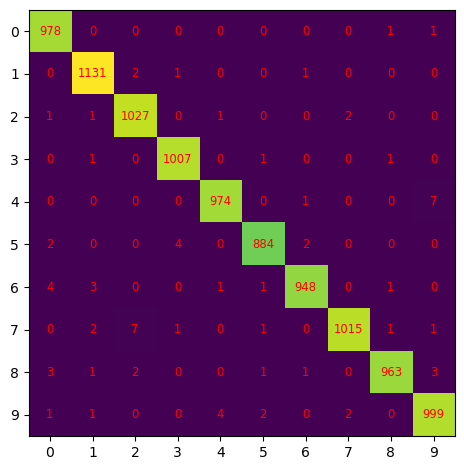

F-score 0: 0.9933976637887252
F-score 1: 0.9942857142857143
F-score 2: 0.9922705314009662
F-score 3: 0.9955511616411271
F-score 4: 0.9928644240570846
F-score 5: 0.9921436588103256
F-score 6: 0.9921507064364208
F-score 7: 0.991695163654128
F-score 8: 0.9922720247295209
F-score 9: 0.9891089108910891


In [10]:
pred = model.predict(X_test)
print('pred.shape = ', pred.shape)
pred = np.argmax(pred, axis=-1)
cm = me.confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])